<a href="https://colab.research.google.com/github/epona7471/YoonKang.github.io/blob/main/n223-evaluation-metrics-for-classification/n223a-evaluation-metrics-for-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 3*

# 📝 Assignment
---

In [ ]:
! pip install -U pandas-profiling
!pip install category_encoders
!pip install --upgrade scikit-learn

In [ ]:
!pip install sweetviz

# Evaluation Metrics for Classification

### 1) Kaggle 챌린지를 이어서 진행합니다.

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sweetviz as sv

In [4]:
# 이번에는 타겟으로 계절독감백신 접종여부를 사용하겠습니다.

target = 'vacc_h1n1_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
# 테스트 데이터 수를 n=14052 로 한정합니다.
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv').iloc[:14052]
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [5]:
train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state,vacc_h1n1_f
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10 - 17 Years,NaN,3,1,2,NaN,2.0,NaN,4,"MSA, Not Principle City",2.0,3.0,5.0,NaN,NaN,9,CALIFORNIA,0
1,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,Very Effective,Very Low,Not Very Worried,Very Effective,Somewhat Low,Not At All Worried,45 - 54 Years,3.0,3,1,2,2.0,1.0,Employed,2,"MSA, Principle City",1.0,0.0,1.0,Accommodation and Food Services Industries,Food Preparation and Serving Related Occupations,7,NEBRASKA,0
2,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0.0,Somewhat Effective,Somewhat Low,Very Worried,Somewhat Effective,Somewhat Low,Very Worried,45 - 54 Years,3.0,3,1,2,2.0,2.0,Employed,1,"MSA, Not Principle City",1.0,2.0,3.0,Transportation and Warehousing Industries,Transportation and Material Moving Occupations,1,MASSACHUSETTS,0
3,2.0,2.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,Very Effective,Very Low,Not Very Worried,Very Effective,Very High,Not At All Worried,35 - 44 Years,4.0,1,2,1,1.0,1.0,Employed,3,"MSA, Not Principle City",2.0,2.0,4.0,"Professional, Scientific, and Technical Servic...",Legal Occupations,6,LOUISIANA,0
4,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Very Effective,Very Low,Not At All Worried,Not At All Effective,Very Low,Not At All Worried,55 - 64 Years,3.0,3,2,2,1.0,1.0,Employed,3,"MSA, Not Principle City",3.0,0.0,3.0,Education Services Industries,Office and Administrative Support Occupations,4,ALABAMA,1


In [59]:
my_report = sv.analyze(train,target_feat='vacc_h1n1_f')

                                             |          | [  0%]   00:00 -> (? left)


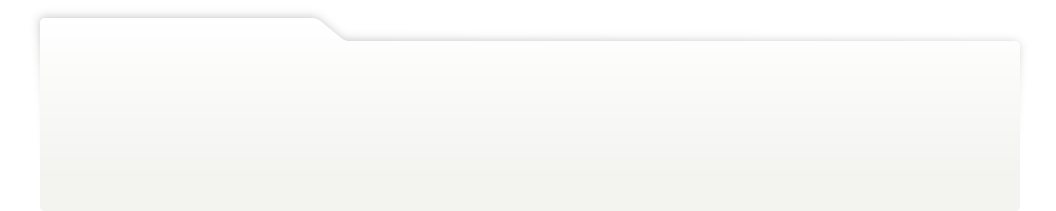
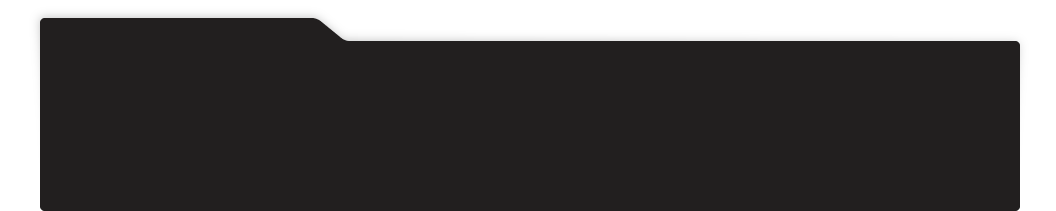
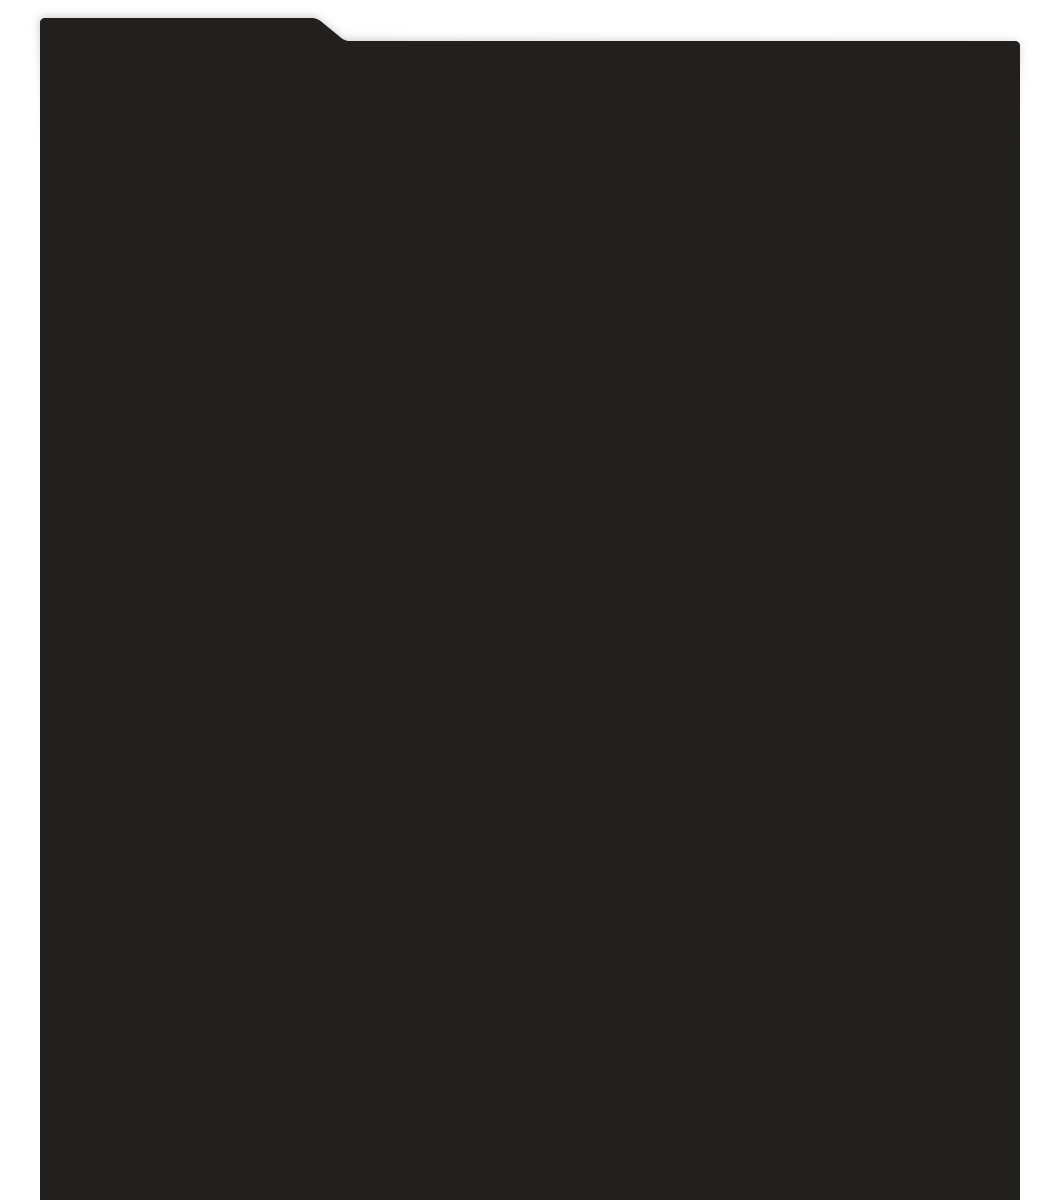
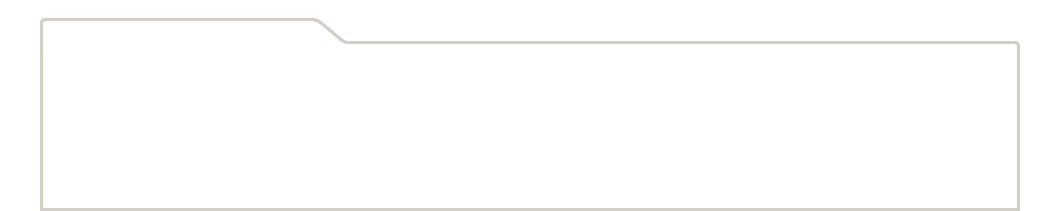
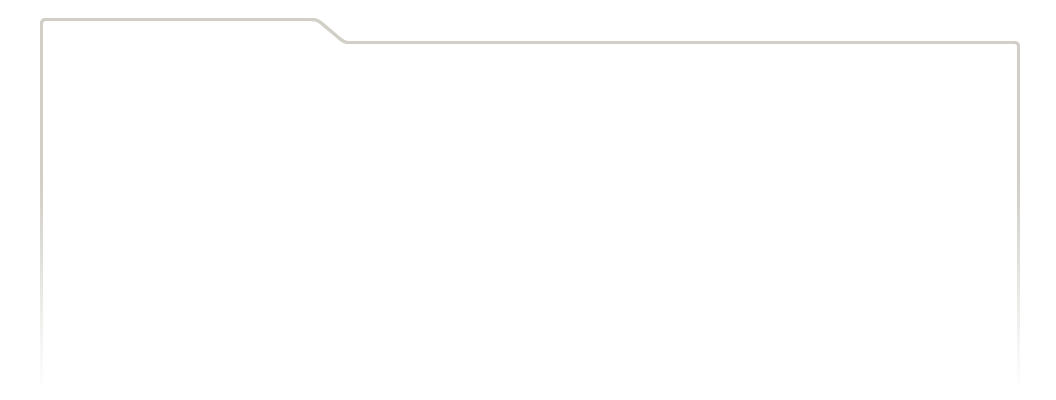
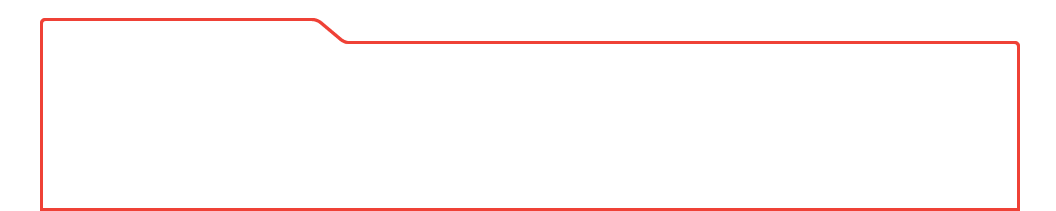
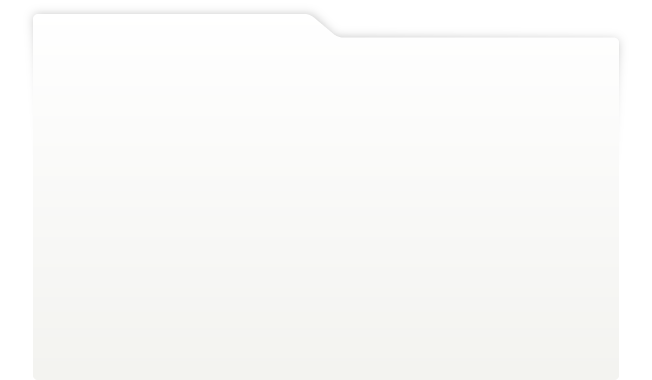
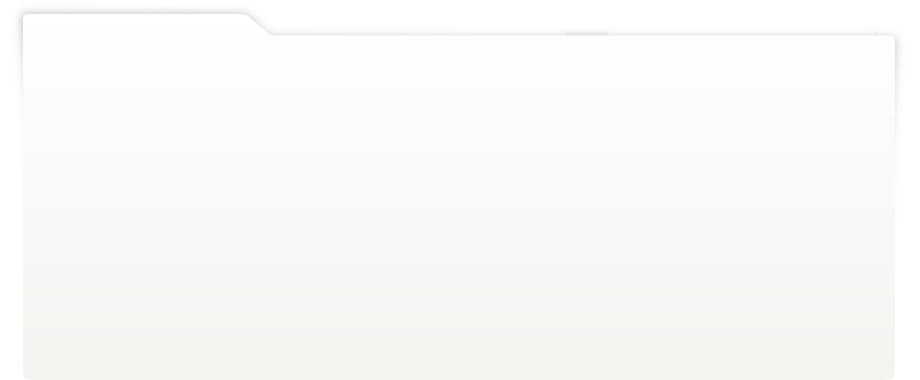
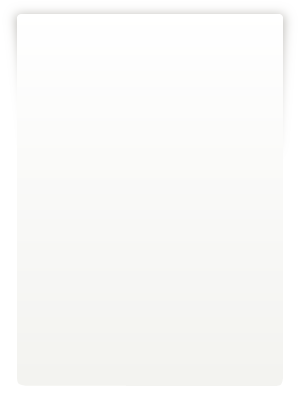
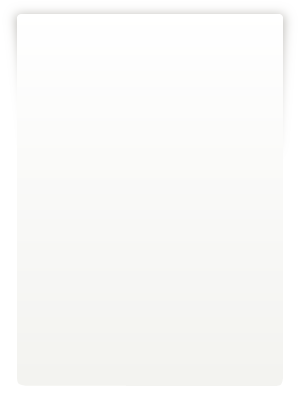
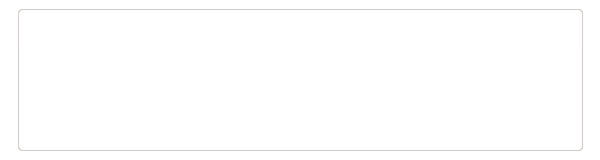
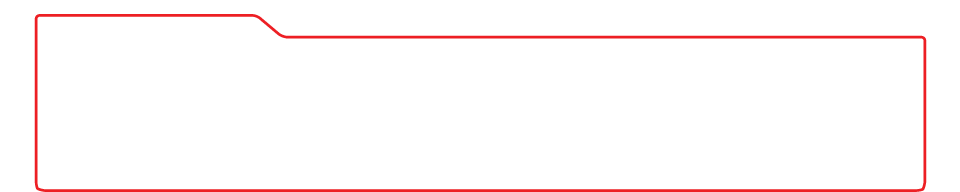
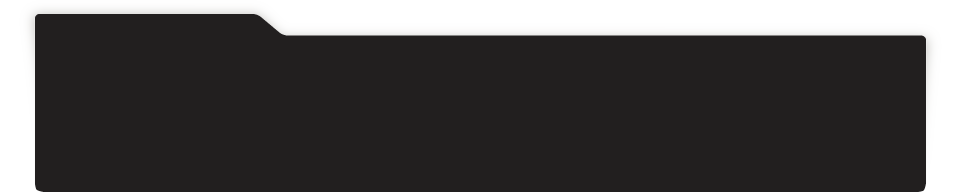
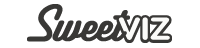
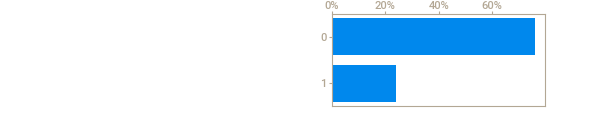
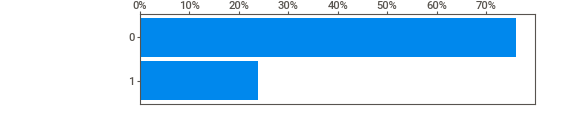
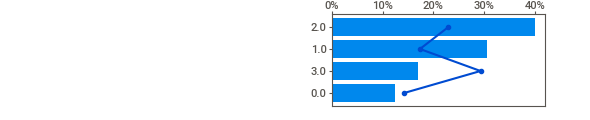
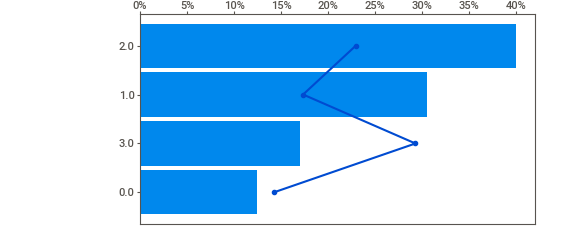
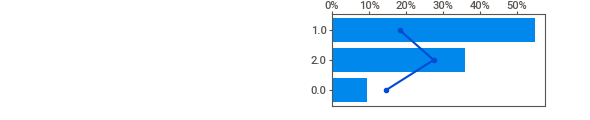
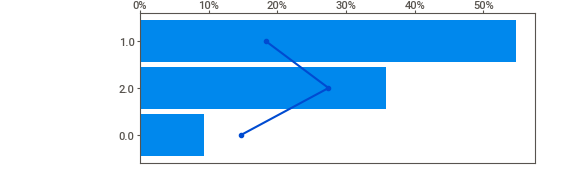
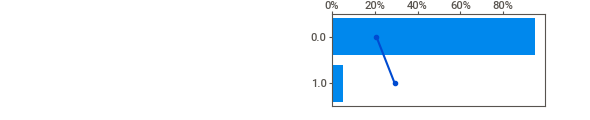
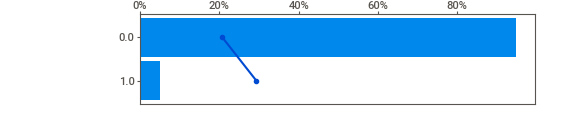
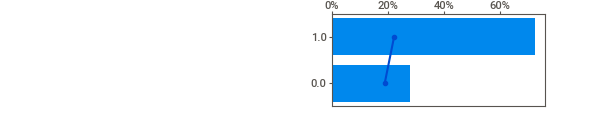
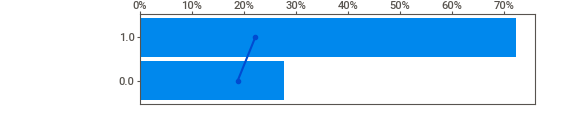
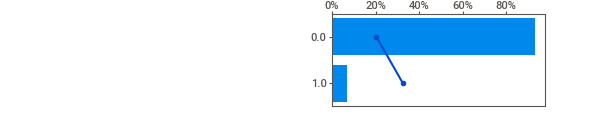
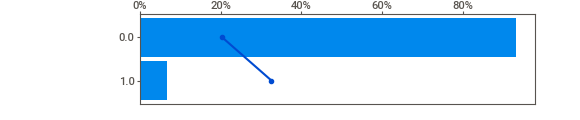
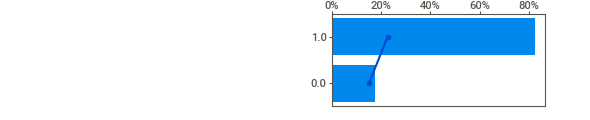
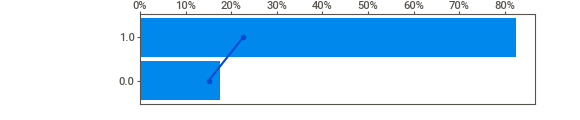
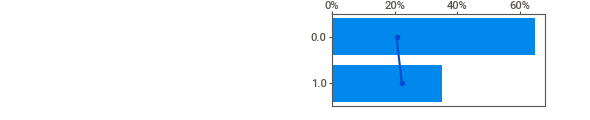
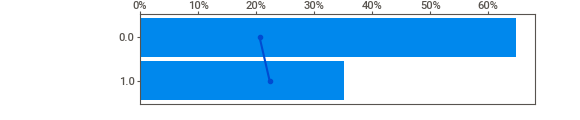
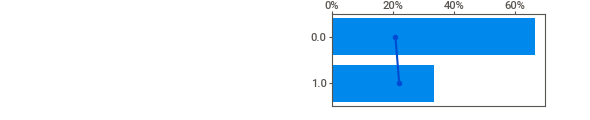
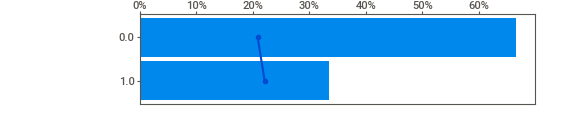
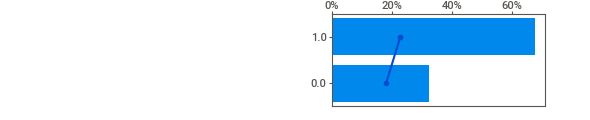
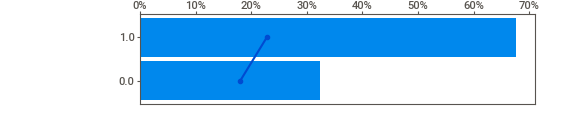
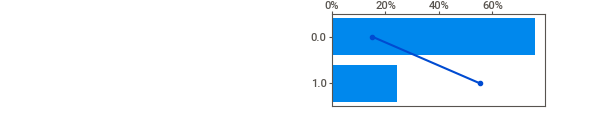
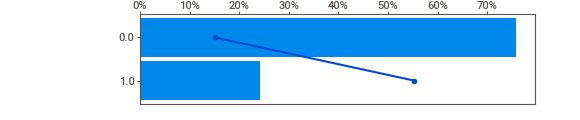
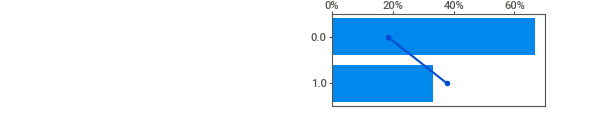
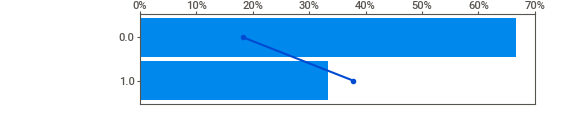
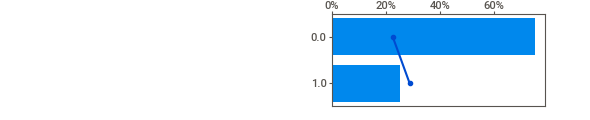
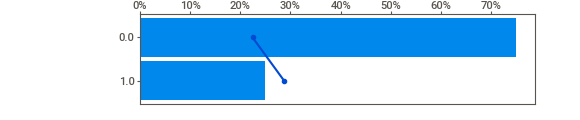
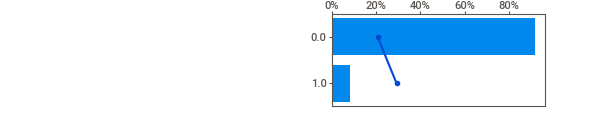
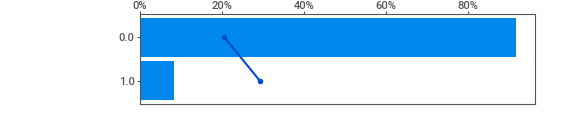
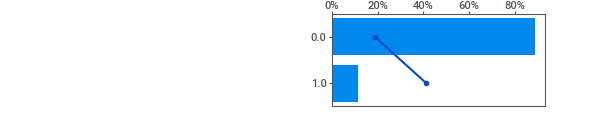
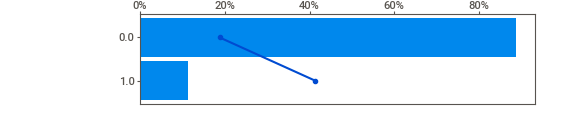
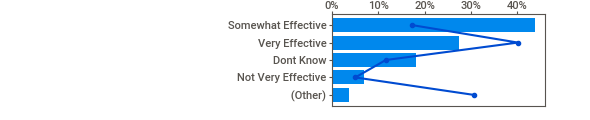
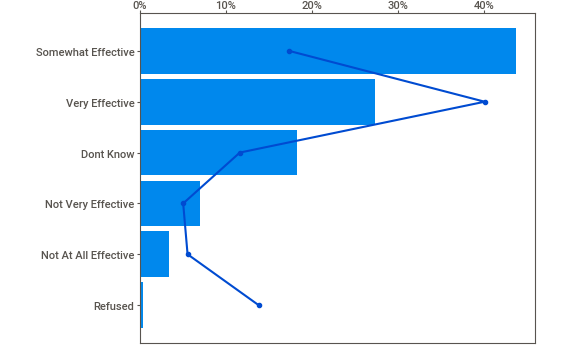
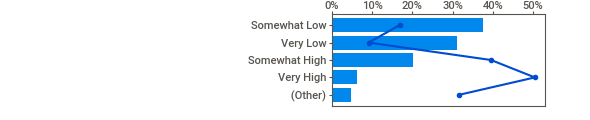
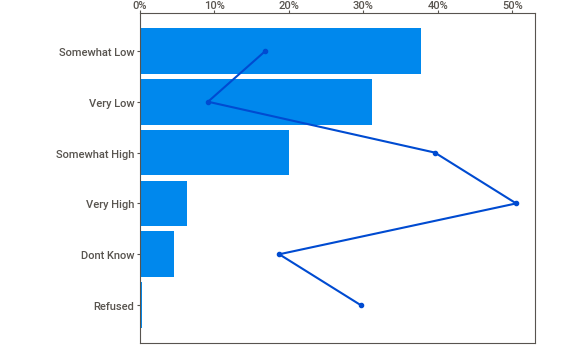
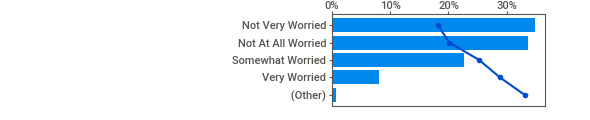
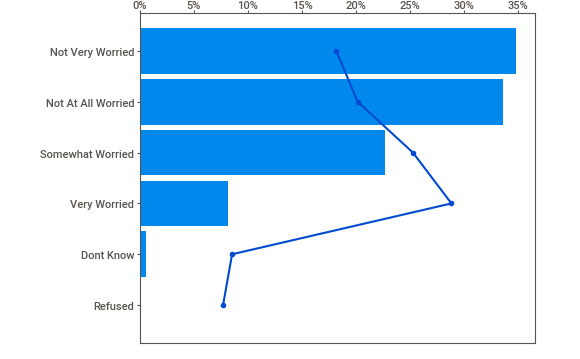
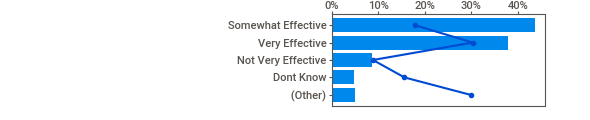
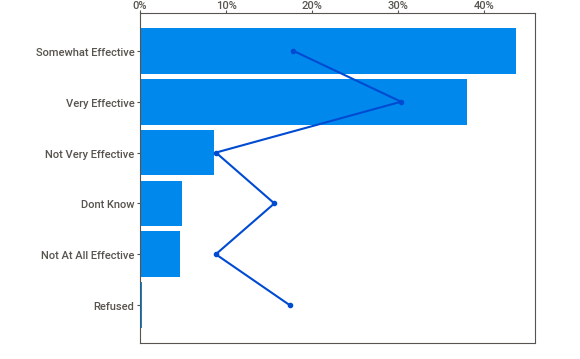
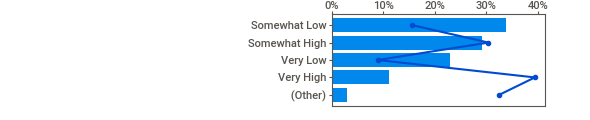
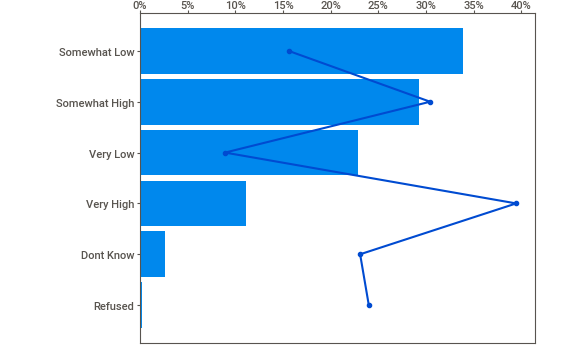
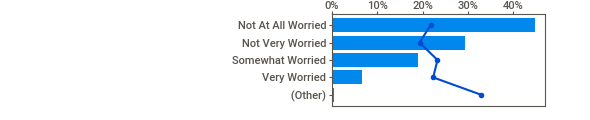
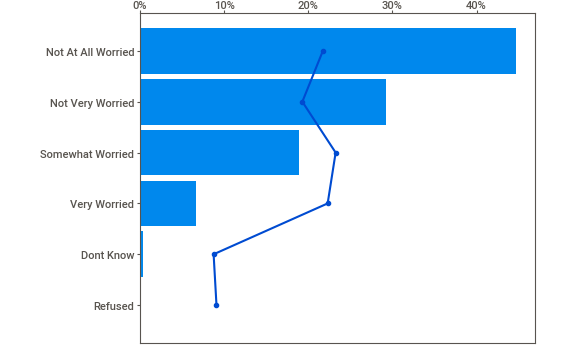
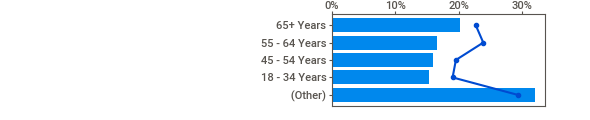
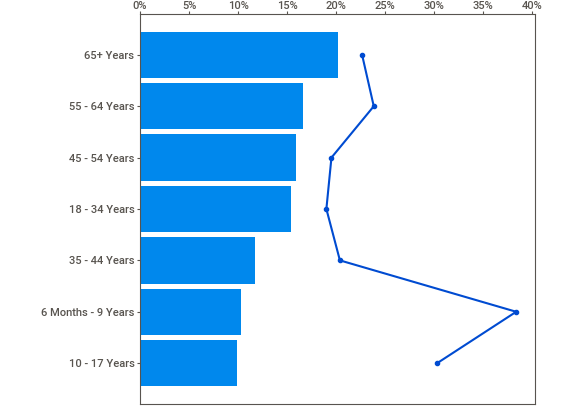
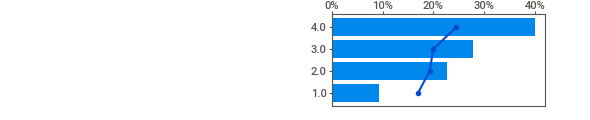
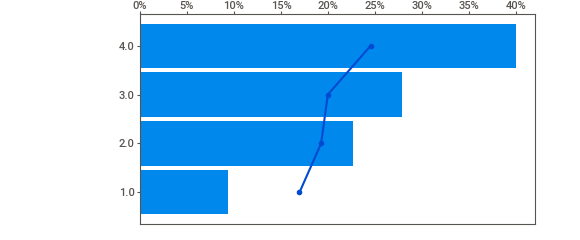
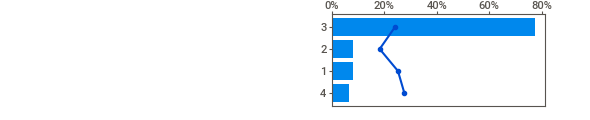
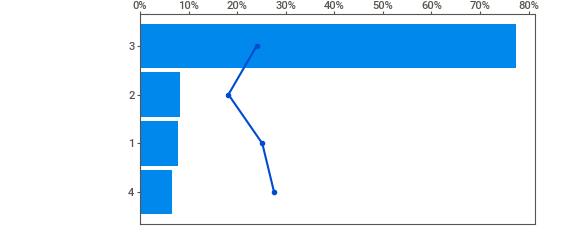
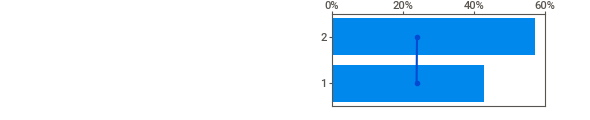
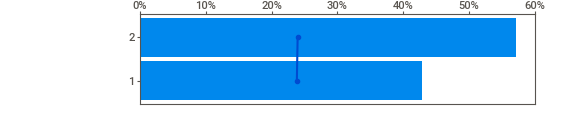
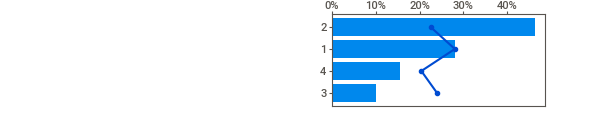
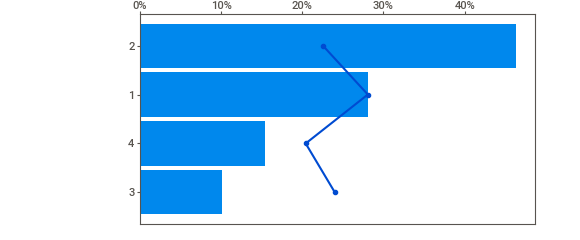
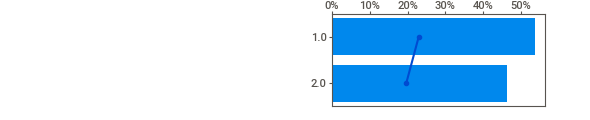
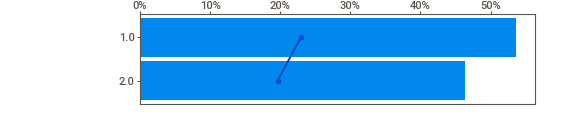
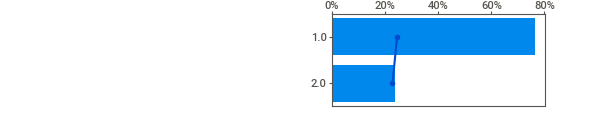
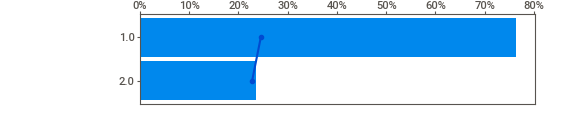
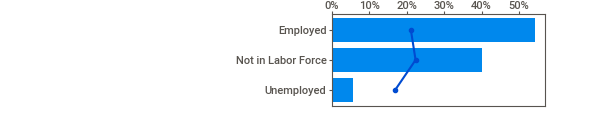
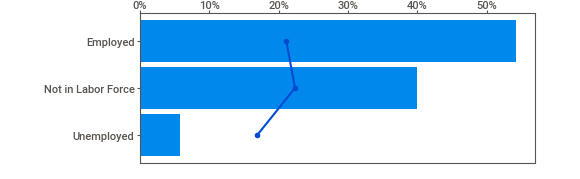
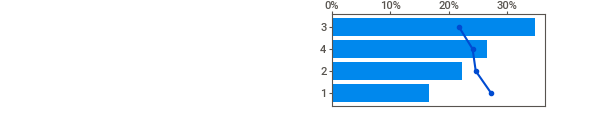
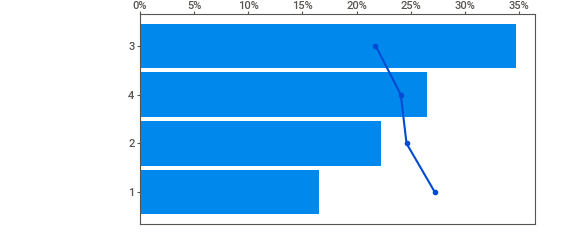
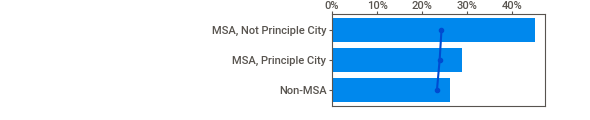
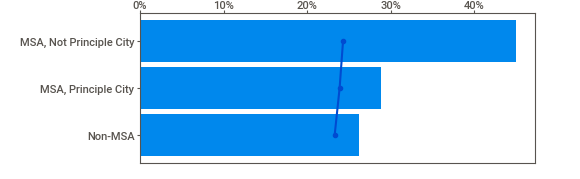
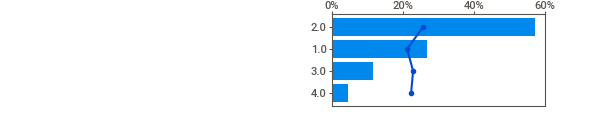
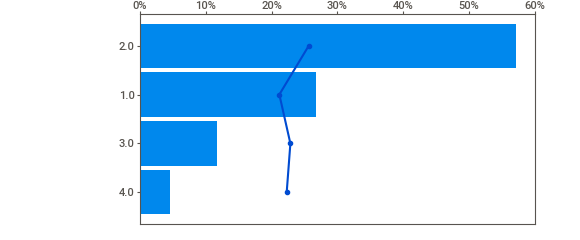
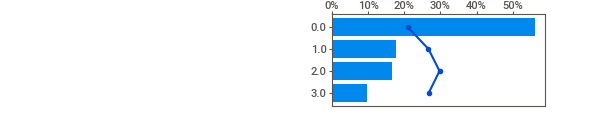
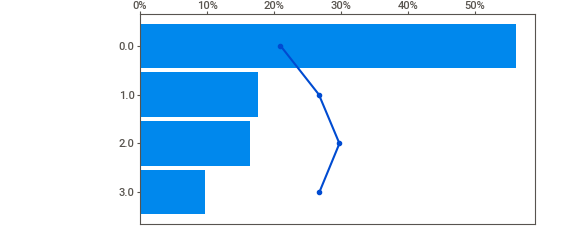
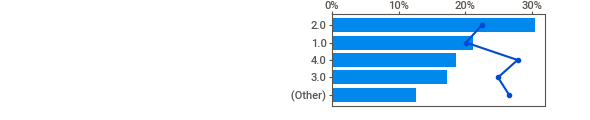
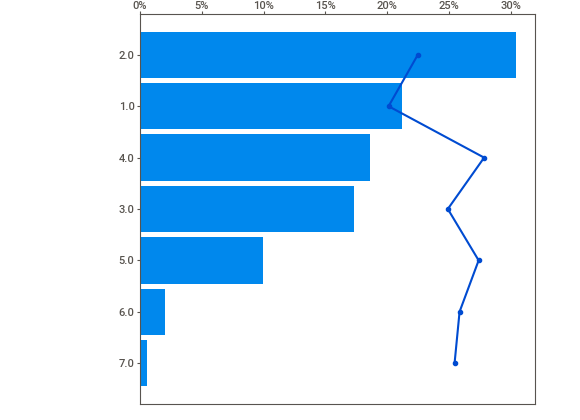
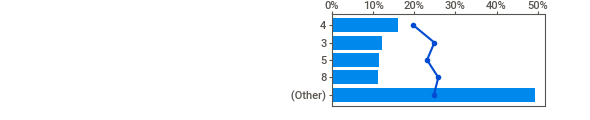
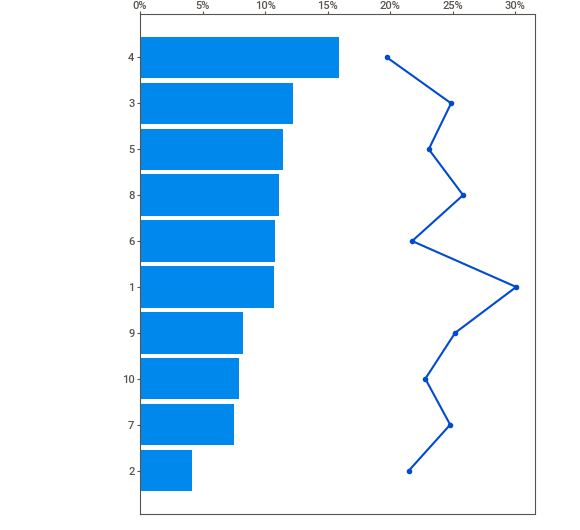
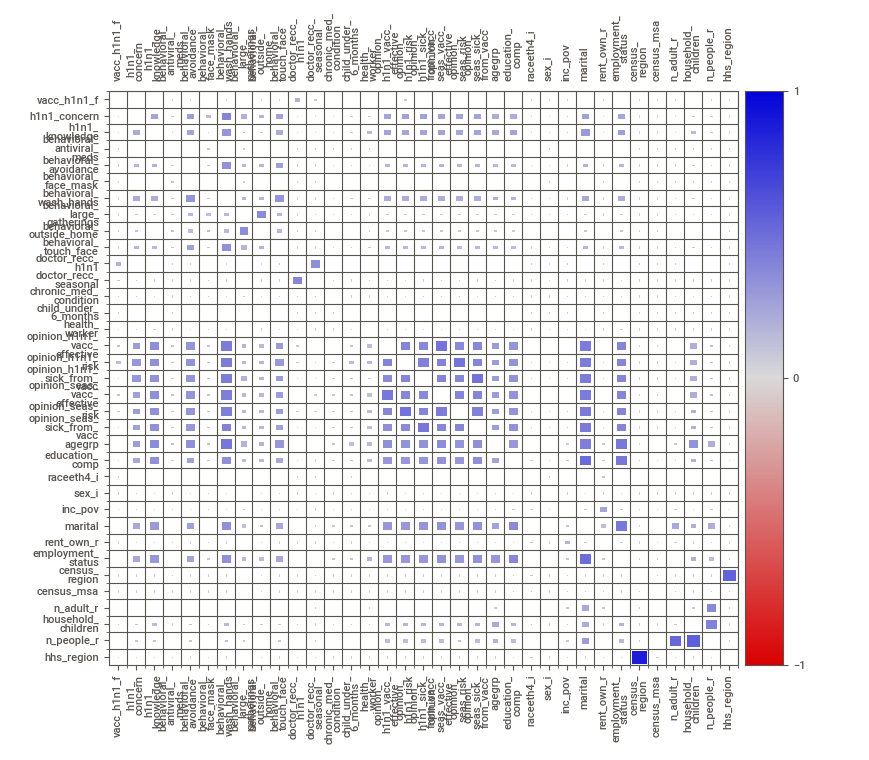
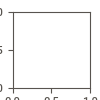

In [60]:
my_report.show_notebook()
#my_report.show_notebook(w=1500, h=300, scale=0.8)
#my_report.show_html(scale=0.9)

category value 중 target variable과 비례관계를 가지는 변수들이 보인다.(예 응답이 긍정적일수록 target variable과 상관계수가 높다) 이것을 ordinal encoding할 때 따로 순서를 지정해줄 수 있을 것이다(추후에 할 예정)

employment_industry, employmeny_occupation feature에서 health care일경우 큰 상관관계를 가진다. 해당건에도 feature engineering을 진행할 수 있을 것이다(추후에 할 예정)

In [8]:
train.isna().sum()

h1n1_concern                    8420
h1n1_knowledge                  8420
behavioral_antiviral_meds       8519
behavioral_avoidance            8672
behavioral_face_mask            8444
behavioral_wash_hands           8471
behavioral_large_gatherings     8514
behavioral_outside_home         8521
behavioral_touch_face           8583
doctor_recc_h1n1                1885
doctor_recc_seasonal            1885
chronic_med_condition           1317
child_under_6_months            9449
health_insurance               19421
health_worker                   9430
opinion_h1n1_vacc_effective     8779
opinion_h1n1_risk               8825
opinion_h1n1_sick_from_vacc     8869
opinion_seas_vacc_effective     8934
opinion_seas_risk               9001
opinion_seas_sick_from_vacc     9065
agegrp                             0
education_comp                 10166
raceeth4_i                         0
sex_i                              0
inc_pov                            0
marital                        10199
r

In [9]:
train.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,census_region,n_adult_r,household_children,n_people_r,hhs_region,vacc_h1n1_f
count,33734.000000,33734.000000,33635.000000,33482.000000,33710.000000,33683.000000,33640.000000,33633.000000,33571.000000,40269.000000,40269.000000,40837.000000,32705.000000,22733.000000,32724.000000,31988.000000,42154.000000,42154.000000,42154.000000,31955.000000,39958.000000,42154.000000,41845.000000,41845.000000,42020.000000,42154.000000,42154.000000
mean,1.617004,1.260272,0.050691,0.727824,0.067784,0.824333,0.355618,0.338239,0.678770,0.241724,0.333433,0.249651,0.083993,0.893063,0.111814,2.980430,2.830313,1.571832,2.132728,1.464059,2.915261,2.706457,1.937460,0.797156,2.738505,5.352991,0.239052
std,0.910609,0.619327,0.219370,0.445087,0.251379,0.380542,0.478707,0.473117,0.466956,0.428133,0.471445,0.432816,0.277382,0.309040,0.315142,1.001355,0.651123,0.494819,0.991463,0.498714,12.597018,1.033513,0.745174,1.039354,1.393333,2.705101,0.426510
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,0.000000,2.000000,3.000000,0.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,2.000000,2.000000,1.000000,1.000000,3.000000,2.000000,0.000000,2.000000,5.000000,0.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,2.000000,4.000000,8.000000,0.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,2.000000,4.000000,2.000000,99.000000,4.000000,4.000000,3.000000,7.000000,10.000000,1.000000


rent_own_r 변수에서 '99' 인 outlier가 보인다. Nan값으로 대체

In [10]:
#data의 수가 32154 이하인 feature는 분석에서 제거
train = train.dropna(axis=1, thresh = len(train) * 0.7)

In [11]:
test = test.drop(columns = ['employment_industry','employment_occupation'])

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42154 entries, 0 to 42153
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 33734 non-null  float64
 1   h1n1_knowledge               33734 non-null  float64
 2   behavioral_antiviral_meds    33635 non-null  float64
 3   behavioral_avoidance         33482 non-null  float64
 4   behavioral_face_mask         33710 non-null  float64
 5   behavioral_wash_hands        33683 non-null  float64
 6   behavioral_large_gatherings  33640 non-null  float64
 7   behavioral_outside_home      33633 non-null  float64
 8   behavioral_touch_face        33571 non-null  float64
 9   doctor_recc_h1n1             40269 non-null  float64
 10  doctor_recc_seasonal         40269 non-null  float64
 11  chronic_med_condition        40837 non-null  float64
 12  child_under_6_months         32705 non-null  float64
 13  health_worker   

In [13]:
from sklearn.model_selection import train_test_split

# 검증세트를 테스트세트와 크기와 같도록 만듭니다.
train, val = train_test_split(train, test_size=len(test), 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((28102, 36), (14052, 36), (14052, 36))

In [14]:
#train.dropna(axis=1, thresh = 10000)

#train.info()

train.shape

(28102, 36)

In [ ]:
def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    #높은 카디널리티를 가지는 특성을 제거합니다.
    selected_cols = df.select_dtypes(include=['number', 'object'])
    colnames = selected_cols.columns.tolist()
    labels = selected_cols.nunique()
    
    selected_features = labels[labels <= 30].index.tolist()
    df = df[selected_features]
    # 새로운 특성을 생성합니다.
    
    #behaviorals = [col for col in df.columns if 'behavioral' in col] 
    #df['behaviorals'] = df[behaviorals].sum(axis=1)
    
    #rent_own_r 이상치는 결측값으로 바꾸어줌
    df.loc[df.rent_own_r > 3, 'rent_own_r'] = np.nan

    #dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    #df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

In [16]:
train.shape

(28102, 35)

In [17]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [18]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 파이프라인을 만들어 봅시다.
pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
)


pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


검증 정확도:  0.8072160546541418


### 2) 본인이 개발한 모델에 대한 confusion matrix를 그려보세요. 
- (도전과제🔥) 각 평가지표에 대해 결과를 최대한 분석하고 무엇이 부족한지, 어떤 방향으로 성능을 높여야 하는지 논하세요.

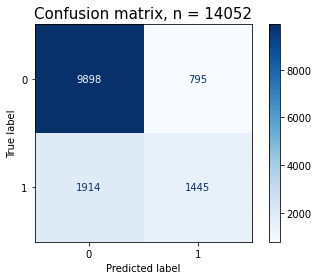

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [20]:
tp = 4442
tn = 6165
fp = 1515
fn = 1930
total = tp + tn + fn + fn

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.93      0.88     10693
           1       0.65      0.43      0.52      3359

    accuracy                           0.81     14052
   macro avg       0.74      0.68      0.70     14052
weighted avg       0.79      0.81      0.79     14052



recall(재현율)의 차이가 매우크다. Threshold를 기본값(0.5)에서 좀 낮추면서, recall score를 개선할 필요가 있다. precision score도 검토하면서 너무 낮아지지는 않는지 동시에 확인해야한다. 

### 3) 랜덤포레스트의 n_estimator를 10, 100, 1000으로 바꾸어 가며 predict_proba를 비교해 보세요

In [22]:
pipe2 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=10, random_state=2, n_jobs=-1)
)


pipe2.fit(X_train, y_train)
y_pred_2 = pipe2.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred_2))

검증 정확도:  0.7962567606034728


In [23]:
pipe3 = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1000, random_state=2, n_jobs=-1)
)


pipe3.fit(X_train, y_train)
y_pred_3 = pipe3.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred_3))

검증 정확도:  0.8096356390549388


In [43]:
from category_encoders import TargetEncoder

pipe4 = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=2, oob_score=True,min_samples_leaf=10)
)


pipe4.fit(X_train, y_train)
y_pred_4 = pipe4.predict(X_val)
print('검증 정확도: ', accuracy_score(y_val, y_pred_4))

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


검증 정확도:  0.8203814403643609


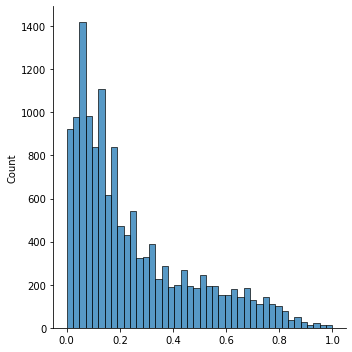

In [24]:
#n_estimator = 100
y_pred_proba = pipe.predict_proba(X_val)[:, 1]
sns.displot(y_pred_proba);

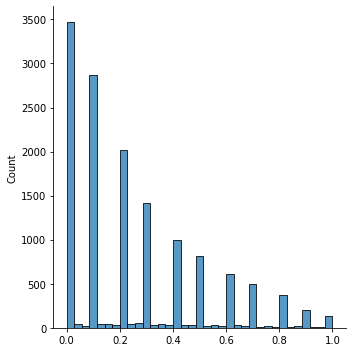

In [36]:
#n_estimator = 10
y_pred_proba_2 = pipe2.predict_proba(X_val)[:, 1]
sns.displot(y_pred_proba_2);

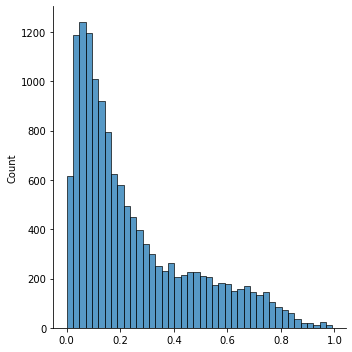

In [26]:
#n_estimator = 1000
y_pred_proba_3 = pipe3.predict_proba(X_val)[:, 1]
sns.displot(y_pred_proba_3);

In [61]:
print('큰수의 법칙에 따라서 n값이 증가할 수록, 특정 value에 집중된 count가 평준화되어 특정 distribution의 근사할 수 있는 curve가 만들어지고 있음을 알 수 있다.')

큰수의 법칙에 따라서 n값이 증가할 수록, 특정 value에 집중된 count가 평준화되어 특정 distribution의 근사할 수 있는 curve가 만들어지고 있음을 알 수 있다.


### 4) 두개 이상의 다른 분류 모델을 학습시켜 ROC curve, AUC 점수를 비교하고 설명합니다.

In [45]:
from sklearn.metrics import roc_curve

# pipe 모델, n_estimator = 100, ordinal encoder
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# pip3 모델, n_estimator = 1000, ordinal encoder
fpr3, tpr3, thresholds3 = roc_curve(y_val, y_pred_proba_3)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr3, 
    'TPRate(Recall)': tpr3, 
    'Threshold': thresholds3
})


y_pred_proba_4 = pipe4.predict_proba(X_val)[:, 1]
# pip4 모델, n_estimator = 1000, target encoder 사용, min_samples_leaf=10 적용
fpr4, tpr4, thresholds4 = roc_curve(y_val, y_pred_proba_4)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr4, 
    'TPRate(Recall)': tpr4, 
    'Threshold': thresholds4
})

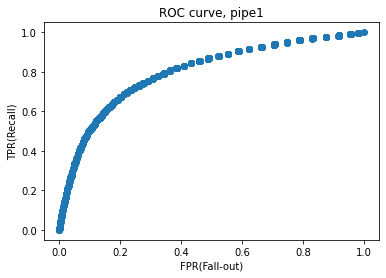

In [46]:
plt.scatter(fpr, tpr)
plt.title('ROC curve, pipe1')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

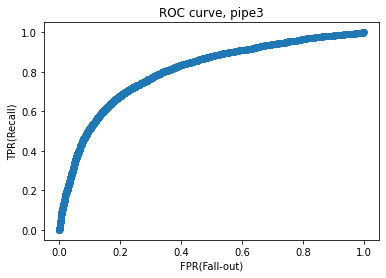

In [48]:
plt.scatter(fpr3, tpr3)
plt.title('ROC curve, pipe3')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

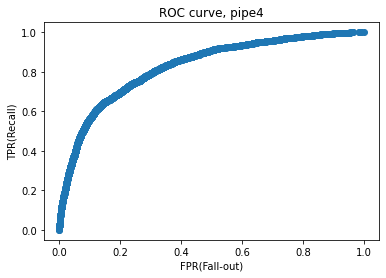

In [49]:
plt.scatter(fpr4, tpr4)
plt.title('ROC curve, pipe4')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

In [55]:
# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

optimal_idx3 = np.argmax(tpr3 - fpr3)
optimal_threshold3 = thresholds3[optimal_idx3]

optimal_idx4 = np.argmax(tpr4 - fpr4)
optimal_threshold4 = thresholds4[optimal_idx4]

print('pipe모델 idx:', optimal_idx, ', threshold:', optimal_threshold)
print('pipe3모델 idx:', optimal_idx3, ', threshold4:', optimal_threshold3)
print('pipe4모델 idx:', optimal_idx4, ', threshold4:', optimal_threshold4)

pipe모델 idx: 597 , threshold: 0.27399999999999997
pipe3모델 idx: 1469 , threshold4: 0.2763003968253969
pipe4모델 idx: 2172 , threshold4: 0.23913234568486255


In [56]:
y_pred_optimal = y_pred_proba >= optimal_threshold

print('pipe모델 classification report')
print(classification_report(y_val, y_pred_optimal))

y_pred_optimal_3 = y_pred_proba_3 >= optimal_threshold3
print('pipe3모델 classification report')
print(classification_report(y_val, y_pred_optimal_3))

y_pred_optimal_4 = y_pred_proba_4 >= optimal_threshold4
print('pipe4모델 classification report')
print(classification_report(y_val, y_pred_optimal_4))

pipe모델 classification report
              precision    recall  f1-score   support

           0       0.89      0.78      0.83     10693
           1       0.50      0.70      0.58      3359

    accuracy                           0.76     14052
   macro avg       0.69      0.74      0.71     14052
weighted avg       0.80      0.76      0.77     14052

pipe3모델 classification report
              precision    recall  f1-score   support

           0       0.89      0.78      0.83     10693
           1       0.50      0.70      0.58      3359

    accuracy                           0.76     14052
   macro avg       0.70      0.74      0.71     14052
weighted avg       0.80      0.76      0.77     14052

pipe4모델 classification report
              precision    recall  f1-score   support

           0       0.90      0.76      0.83     10693
           1       0.50      0.74      0.59      3359

    accuracy                           0.76     14052
   macro avg       0.70      0.75      

In [58]:
from sklearn.metrics import roc_auc_score
auc_score = roc_auc_score(y_val, y_pred_proba)
print(auc_score)

auc_score3 = roc_auc_score(y_val, y_pred_proba_3)
print(auc_score3)

auc_score4 = roc_auc_score(y_val, y_pred_proba_4)
print(auc_score4)

0.7992579553968623
0.8036894784191465
0.8280559991070718


모델간 F1 score의 차이는 미미했다.
pipe4 model이 가장 높은 AUC scroe를 기록했다. 즉 pip4 model이 negative, positive에 대한 구분이 제일 우수함을 의미한다.

### 5) Kaggle 챌린지에 결과를 submission 합니다.

In [62]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
y_pred_test = pipe2.predict(X_test)

sample_submission['vacc_h1n1_f'] =  y_pred_test

sample_submission.to_csv('/content/drive/My Drive/Code/submission_n222_1.csv',index= False)